In [1]:
import sys
sys.path.append('D:\\RCWA\\')

import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import cond
import cmath;
from scipy import linalg as LA
from numpy.linalg import solve as bslash
import time
from RCWA_1D_functions.grating_fft.grating_conv import *

def nonHermitianEigenSorter(eigenvalues):
    N = len(eigenvalues);
    sorted_indices=[];
    sorted_eigs = [];
    for i in range(N):
        eig = eigenvalues[i];
        if(np.real(eig)>0 and np.imag(eig) == 0):
            sorted_indices.append(i); sorted_eigs.append(eig);
        elif(np.real(eig)==0 and np.imag(eig) > 0):
            sorted_indices.append(i); sorted_eigs.append(eig);
        elif(np.real(eig)>0 and abs(np.imag(eig)) > 0):
            sorted_indices.append(i); sorted_eigs.append(eig);
    return sorted_eigs, sorted_indices;

# Moharam et. al Formulation for stable and efficient implementation for RCWA
plt.close("all")
'''
1D TM implementation of PLANAR DIFFRACTiON
STILL NOT WORKING YET

only: sign convention is exp(-ikr) (is the positive propagating wave), so loss is +  not - 
source for fourier decomps is from the paper: Formulation for stable and efficient implementation of
the rigorous coupled-wave analysis of binary gratings by Moharam et. al
'''

# plt.plot(x, np.real(fourier_reconstruction(x, period, 1000, 1,np.sqrt(12), fill_factor = 0.1)));
# plt.title('check that the analytic fourier series works')
# #'note that the lattice constant tells you the length of the ridge'
# plt.show()

L0 = 1e-6;
e0 = 8.854e-12;
mu0 = 4*np.pi*1e-8;
fill_factor = 0.3; # 50% of the unit cell is the ridge material


num_ord = 3; #INCREASING NUMBER OF ORDERS SEEMS TO CAUSE THIS THING TO FAIL, to many orders induce evanescence...particularly

               # when there is a small fill factor
PQ = 2*num_ord+1;
indices = np.arange(-num_ord, num_ord+1)

n_ridge = 3.48;              # ridge
n_groove = 3.48;                # groove (unit-less)
lattice_constant = 0.7;  # SI units
# we need to be careful about what lattice constant means
# in the gaylord paper, lattice constant exactly means (0, L) is one unit cell


d = 0.46;               # thickness, SI units
Nx = 2*256;
eps_r = n_groove**2*np.ones((2*Nx, 1)); #put in a lot of points in eps_r
eps_xz = np.zeros((2*Nx,1));
border = int(2*Nx*fill_factor);
eps_r[0:border] = n_ridge**2;
eps_xz[0:border] = 1;
#eps_xz[:] =12 ;
eps_zx = eps_xz;

fft_fourier_array = grating_fft(eps_r);
x = np.linspace(-lattice_constant,lattice_constant,1000);
period = lattice_constant;

## simulation parameters
theta = (0)*np.pi/180;



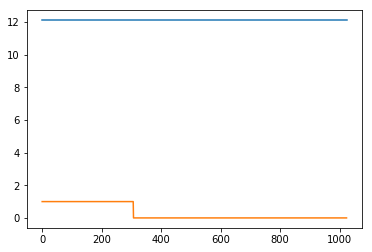

In [2]:
plt.figure();
plt.plot(eps_r)
plt.plot(eps_xz);
plt.show()

In [3]:
## construct permittivity harmonic components E
#fill factor = 0 is complete dielectric, 1 is air

##construct convolution matrix
Ezz = np.zeros((2 * num_ord + 1, 2 * num_ord + 1)); Ezz = Ezz.astype('complex')
p0 = Nx; #int(Nx/2);
p_index = np.arange(-num_ord, num_ord + 1);
q_index = np.arange(-num_ord, num_ord + 1);
fourier_array = fft_fourier_array;#fourier_array_analytic;
detected_pffts = np.zeros_like(Ezz);
for prow in range(2 * num_ord + 1):
    # first term locates z plane, 2nd locates y coumn, prow locates x
    row_index = p_index[prow];
    for pcol in range(2 * num_ord + 1):
        pfft = p_index[prow] - p_index[pcol];
        detected_pffts[prow, pcol] = pfft;
        Ezz[prow, pcol] = fourier_array[p0 + pfft];  # fill conv matrix from top left to top right

# Exz = np.zeros_like(Ezz);
# Ezx = np.zeros_like(Ezz);
# Exz = 2*np.eye(PQ)
# Ezx = Exz;
# print((Exz.shape, Ezx.shape, Ezz.shape))

## FFT of 1/e;
inv_fft_fourier_array = grating_fft(1/eps_r);
##construct convolution matrix
E_conv_inv = np.zeros((2 * num_ord + 1, 2 * num_ord + 1));
E_conv_inv = E_conv_inv.astype('complex')
p0 = Nx;
p_index = np.arange(-num_ord, num_ord + 1);
for prow in range(2 * num_ord + 1):
    # first term locates z plane, 2nd locates y coumn, prow locates x
    for pcol in range(2 * num_ord + 1):
        pfft = p_index[prow] - p_index[pcol];
        E_conv_inv[prow, pcol] = inv_fft_fourier_array[p0 + pfft];  # fill conv matrix from top left to top right



In [4]:
## specialized fourier matrices for exz

exzzxzz = eps_xz*eps_zx/eps_r;
exzzz = eps_xz/eps_r;
ezxzz = eps_zx/eps_r;

be = 1/(eps_r - eps_xz*eps_zx/eps_r);
# plt.figure();
# plt.plot(exzzxzz) #verify anisotropy is localized
# plt.plot(exzzz )
# plt.plot(ezxzz)
# plt.show()

Exzzxzz = np.zeros((2 * num_ord + 1, 2 * num_ord + 1)); Exzzxzz  = Exzzxzz.astype('complex')
Exzzz = np.zeros((2 * num_ord + 1, 2 * num_ord + 1)); Exzzz  = Exzzz.astype('complex')
bEr = np.zeros((2 * num_ord + 1, 2 * num_ord + 1)); bEr  = bEr.astype('complex')

fourier_array_be = grating_fft(be);
fourier_array_xzzx = grating_fft(exzzxzz);
fourier_array_xzzz = grating_fft(exzzz);
for prow in range(2 * num_ord + 1):
    # first term locates z plane, 2nd locates y coumn, prow locates x
    row_index = p_index[prow];
    for pcol in range(2 * num_ord + 1):
        pfft = p_index[prow] - p_index[pcol];
        detected_pffts[prow, pcol] = pfft;
        Exzzxzz[prow, pcol] = fourier_array_xzzx[p0 + pfft];  # fill conv matrix from top left to top right

for prow in range(2 * num_ord + 1):
    # first term locates z plane, 2nd locates y coumn, prow locates x
    row_index = p_index[prow];
    for pcol in range(2 * num_ord + 1):
        pfft = p_index[prow] - p_index[pcol];
        detected_pffts[prow, pcol] = pfft;
        Exzzz[prow, pcol] = fourier_array_xzzx[p0 + pfft];  # fill conv matrix from top left to top right
        
for prow in range(2 * num_ord + 1):
    # first term locates z plane, 2nd locates y coumn, prow locates x
    row_index = p_index[prow];
    for pcol in range(2 * num_ord + 1):
        pfft = p_index[prow] - p_index[pcol];
        detected_pffts[prow, pcol] = pfft;
        bEr[prow, pcol] = fourier_array_be[p0 + pfft];  # fill conv matrix from top left to top right
Ezxzz = Exzzz

Does it make sense that most eigenvalues are imaginary in a weakly anisotropic case?

Second order eigenvalue equation
\begin{equation}
    M\lambda^2+C\lambda +K = 0
\end{equation}

generalized eigenvalue problem in numpy:
scipy.linalg.eig(a,b); # b is the rhs, typically an identity matrix

Energy conservation implies that
\begin{equation}
\epsilon = \epsilon ^*
\end{equation}

so for our naive test system where the anisotropy is just a linear term, nothing should happen

Conditioning in the TM case shows that we can get condition numbers up to 10000, but this still doesn't cause any numerical errors in the first order formulation of the TM solver, so there must be some bug in our code.

### sign convention
SIGN CONVENTION: 
\begin{equation}
e^{j\mathbf{k\cdot r} -i\omega t}
\end{equation}
(Make sure this matches with our overleaf Documentation)


### Dealing with the Products of the E-matrices
All E matrices are convolution matrices, HOWEVER, we should only do matrix multiply for E on a K vector. For two E's, I'm not sure, it looks like the product of two fourier series. The fourier series of a product of two functions is the product of their Fourier series (i.e. the convolution theorem). However, E are not actual representations of the Fourier series.

In [5]:
## IMPORTANT TO NOTE: the indices for everything beyond this points are indexed from -num_ord to num_ord+1
## alternate construction of 1D convolution matrix

PQ =2*num_ord+1;
I = np.eye(PQ)
zeros = np.zeros((PQ, PQ))
# E is now the convolution of fourier amplitudes
wavelength_scan = np.linspace(0.5, 3, 200)
spectra = list();
spectra_T = list();
for wvlen in wavelength_scan:
    j = cmath.sqrt(-1);
    lam0 = wvlen;     k0 = 2 * np.pi / lam0; #free space wavelength in SI units
    print('wavelength: ' + str(wvlen));
    ## =====================STRUCTURE======================##

    ## Region I: reflected region (half space)
    n1 = 1;#cmath.sqrt(-1)*1e-12; #apparently small complex perturbations are bad in Region 1, these shouldn't be necessary

    ## Region 2; transmitted region
    n2 = 1;

    #from the kx_components given the indices and wvln
    kx_array = k0*(n1*np.sin(theta) + indices*(lam0 / lattice_constant)); #0 is one of them, k0*lam0 = 2*pi
    k_xi = kx_array;
    ## IMPLEMENT SCALING: these are the fourier orders of the x-direction decomposition.
    KX = np.diag((k_xi/k0)); #singular since we have a n=0, m= 0 order and incidence is normal

    ## one thing that isn't obvious is that are we doing element by element division or is it matricial
    B = (KX@bslash(Ezz, KX) - I);
    
    ## SIGN MISMATCH WITH DERIVATION, first term should be positive but in the notes ,it's negative: FIX (3/4/2019)
    #bE = np.linalg.inv(E_conv_inv) - Exzzxzz #bslash(Ezz,(Exz@Ezx)); #/Ezz;
    bE = np.linalg.inv(bEr);
    
    G = j* Ezxzz @ KX#j*bslash(Ezz,Ezx) @ KX;
    #G = j*(Ezx/Ezz)@KX #we should not do pointwise division of these epsilon matrices.
    H = -j*KX @Exzzz; #j*KX @bslash(Ezz, Exz);
    #print((bE.shape,G.shape, H.shape))
    print('conditioning of B and bE: '+str((np.linalg.cond(B), np.linalg.cond(bE))))
    print('conditioning of G and H: '+str((np.linalg.cond(G), np.linalg.cond(H))))


    M = np.linalg.inv(bE);
    K = -(B + H@np.linalg.inv(bE)@G);
    C = -np.linalg.inv(bE)@G - H@np.linalg.inv(bE);
    Z = np.zeros_like(M);
    I = np.eye(M.shape[0], M.shape[1]);
        
    OA = np.block([[M, Z],[Z, I]])
    OB = np.block(np.block([[C, K],[-I, Z]]))

    ## these matrices aren't poorly conditioned
    print('conditioning of eigenvalue prob: '+str((np.linalg.cond(OA), np.linalg.cond(OB))))
    ## solve eiegenvalues;
    beigenvals, bigW = LA.eig(OB, OA); #W contains eigenmodes of the form (lambda x, x)

    ## AT THIS POINT, we have still extracted TWO times the number of eigenvalues...
    #try rounding...
    rounded_beigenvals = np.array([round(i,10) for i in beigenvals])
    print(rounded_beigenvals)
    #quadrant_sort = [1 if abs(np.real(i))>=0 and np.imag(i)>=0 else 0 for i in rounded_beigenvals];

    sorted_eigs, sorted_indices = nonHermitianEigenSorter(rounded_beigenvals)
    # sorted_indices = np.nonzero(quadrant_sort)[0]
    print(len(sorted_indices))
    #sorted_indices = np.argsort(np.real(rounded_beigenvals))
    sorted_eigenmodes = bigW[:, sorted_indices];
    #print(sorted_eigenmodes)
    #adding real and imaginary parts seems to work...
    sorted_eigenvals = beigenvals[sorted_indices]
    print(sorted_eigenvals)
    W = sorted_eigenmodes[PQ:,:]
    eigenvals_wp = (sorted_eigenvals[0:PQ]);

#     plt.plot(np.real(beigenvals), np.imag(beigenvals), '.', markersize = 20);
#     plt.plot(np.real(eigenvals_wp), (np.imag(eigenvals_wp)), '.r', markersize = 10)
#     plt.legend(('original', 'sorted'))
#     plt.show();

    Q = np.diag(eigenvals_wp); #eigenvalue problem is for kz, not kz^2

    ## IS THIS RIGHT? #Q is a diagonal matrix of eigenvalues. W contains modes in columns... we want to column scale
    # so Q should be on the RHS of W.
    V = np.linalg.inv(bE)@(W @ Q +  H@W);

    #enforcing negative sign convention.
    X = np.diag(np.exp(-k0*np.diag(Q)*d)); #this is poorly conditioned because exponentiation
    ## pointwise exponentiation vs exponentiating a matrix

    ## observation: almost everything beyond this point is worse conditioned
    k_I = k0**2*(n1**2 - (k_xi/k0)**2);                 #k_z in reflected region k_I,zi
    k_II = k0**2*(n2**2 - (k_xi/k0)**2);   #k_z in transmitted region
    ## are these formulas correct, as they only pertain teo the reflected and transmitted regions.
    
    k_I = k_I.astype('complex'); k_I = np.sqrt(k_I);
    k_II = k_II.astype('complex'); k_II = np.sqrt(k_II);
    Z_I = np.diag(k_I / (n1**2 * k0 ));
    Z_II = np.diag(k_II /(n2**2 * k0));
    delta_i0 = np.zeros((len(kx_array),1));
    delta_i0[num_ord] = 1;
    n_delta_i0 = delta_i0*j*np.cos(theta)/n1;
    
    O = np.block([
        [W, W],
        [V,-V]
    ]); #this is much better conditioned than S..
    print('condition of O: '+str(np.linalg.cond(O)))
    print((np.linalg.cond(W), np.linalg.cond(V)))
    # plt.imshow(abs(O))
    # plt.show();
    f = I;
    g = j * Z_II; #all matrices
    fg = np.concatenate((f,g),axis = 0)
    ab = np.matmul(np.linalg.inv(O),fg);
    a = ab[0:PQ,:];
    b = ab[PQ:,:];

    term = X @ a @ np.linalg.inv(b) @ X;
    f = W @ (I + term);
    g = V@(-I+term);
    
    ## does this change?, I think it might...
    T = np.linalg.inv(np.matmul(j*Z_I, f) + g);
    T = np.dot(T, (np.dot(j*Z_I, delta_i0) + n_delta_i0));
    R = np.dot(f,T)-delta_i0; #shouldn't change
    T = np.dot(np.matmul(np.linalg.inv(b),X),T)

    ## calculate diffraction efficiencies
    #I would expect this number to be real...
    DE_ri = R*np.conj(R)*np.real(np.expand_dims(k_I,1))/(k0*n1*np.cos(theta));
    DE_ti = T*np.conj(T)*np.real(np.expand_dims(k_II,1)/n2**2)/(k0*np.cos(theta)/n1);

    print('R(lam)='+str(np.sum(DE_ri))+' T(lam) = '+str(np.sum(DE_ti)))
    spectra.append(np.sum(DE_ri)); #spectra_T.append(T);
    spectra_T.append(np.sum(DE_ti))



wavelength: 0.5
conditioning of B and bE: (1.6107332707942463, 1.006781840865403)
conditioning of G and H: (1.4729122928958623e+18, 2.2551825860316815e+18)
conditioning of eigenvalue prob: (12.110399993865716, 1.614787680355816)
[ 0.00577608-2.73855171j -0.00577608-2.73855171j  0.00516772-3.16959462j
 -0.00516772-3.16959462j  0.00931268-3.40236758j -0.00931268-3.40236758j
 -0.        -3.47475216j  0.00577608+2.73855171j -0.00577608+2.73855171j
  0.00516772+3.16959462j -0.00516772+3.16959462j -0.        +3.47475216j
  0.00931268+3.40236758j -0.00931268+3.40236758j]
7
[ 5.77607761e-03-2.73855171j  5.16771998e-03-3.16959462j
  9.31268051e-03-3.40236758j  5.77607761e-03+2.73855171j
  5.16771998e-03+3.16959462j -4.23264866e-16+3.47475216j
  9.31268051e-03+3.40236758j]
condition of O: 106.23933702822355
(76.85268543054148, 24.448295806353325)
R(lam)=(0.5986922190504503+0j) T(lam) = (0.25346900668025907+0j)
wavelength: 0.5125628140703518
conditioning of B and bE: (1.6623932520931326, 1.006781

condition of O: 191.50161511345425
(107.30535792408527, 27.70511969414859)
R(lam)=(0.1077748232210848+0j) T(lam) = (0.878595736538665+0j)
wavelength: 1.1030150753768844
conditioning of B and bE: (5.558731671161375, 1.006781840865403)
conditioning of G and H: (7.03305539862682e+17, 1.2430328441807844e+18)
conditioning of eigenvalue prob: (12.110399993865716, 5.62460655855417)
[-3.21374607+0.j         -3.18857125-0.j          3.21374607-0.j
  3.18857125-0.j          0.        +3.47437057j  0.01997833+3.09906002j
 -0.01997833+3.09906002j -0.01202459+1.46870111j  0.01202459+1.46870111j
  0.        -3.47437057j -0.01997833-3.09906002j  0.01997833-3.09906002j
 -0.01202459-1.46870111j  0.01202459-1.46870111j]
7
[3.21374607e+00-4.02481381e-16j 3.18857125e+00-4.22889608e-15j
 6.75528124e-16+3.47437057e+00j 1.99783268e-02+3.09906002e+00j
 1.20245917e-02+1.46870111e+00j 1.99783268e-02-3.09906002e+00j
 1.20245917e-02-1.46870111e+00j]
condition of O: 194.00399498402587
(91.43090379042948, 27.112692

R(lam)=(0.24994393566828954+0j) T(lam) = (0.8219533467444478+0j)
wavelength: 1.706030150753769
conditioning of B and bE: (6.70096612757427, 1.006781840865403)
conditioning of G and H: (1.7266246143053238e+18, 9.63665633338147e+17)
conditioning of eigenvalue prob: (12.110399993865716, 6.735780969697369)
[ 6.44949342-0.j          6.41080352+0.j         -6.44949342+0.j
 -6.41080352+0.j          3.43457533+0.j          3.39704978+0.j
 -3.43457533-0.j         -3.39704978+0.j         -0.        +3.47431302j
 -0.03072642+2.47929992j  0.03072642+2.47929992j  0.        -3.47431302j
  0.03072642-2.47929992j -0.03072642-2.47929992j]
7
[ 6.44949342e+00-1.02084014e-15j  6.41080352e+00+2.47401511e-17j
  3.43457533e+00+1.19648823e-15j  3.39704978e+00+4.09022139e-15j
 -4.28283552e-16+3.47431302e+00j  3.07264186e-02+2.47929992e+00j
  3.07264186e-02-2.47929992e+00j]
condition of O: 146.63921427214058
(109.01207262722873, 30.082548343538416)
R(lam)=(0.29764182953003715+0j) T(lam) = (0.7851615288504675+0j

R(lam)=(0.7144870750481955+0j) T(lam) = (0.28758679144699856+0j)
wavelength: 2.221105527638191
conditioning of B and bE: (38.43547256671672, 1.006781840865403)
conditioning of G and H: (2.2243217521061327e+18, 1.1575762604733117e+18)
conditioning of eigenvalue prob: (12.110399993865716, 39.08617749170924)
[ 8.88428235+0.j          8.83398493+0.j         -8.88428235-0.j
 -8.83398493-0.j          5.33266021-0.j          5.28370008-0.j
 -5.33266021-0.j         -5.28370008-0.j          0.        +3.47429608j
  0.        -3.47429608j  0.03979099+1.42066632j -0.03979099+1.42066632j
  0.03979099-1.42066632j -0.03979099-1.42066632j]
7
[8.88428235e+00+7.78530495e-15j 8.83398493e+00+1.68234621e-15j
 5.33266021e+00-2.94517652e-15j 5.28370008e+00-3.24054161e-15j
 3.50572317e-16+3.47429608e+00j 3.97909922e-02+1.42066632e+00j
 3.97909922e-02-1.42066632e+00j]
condition of O: 433.5441545670767
(28.465231379279285, 50.88585145733575)
R(lam)=(0.7123505033741578+0j) T(lam) = (0.2895006069044608+0j)
wavel

condition of O: 7.858641599217016
(5.921224482884725, 1.2441296775592308)
R(lam)=(0.4458729645581796+0j) T(lam) = (0.5541738904202748+0j)
wavelength: 2.698492462311558
conditioning of B and bE: (44.22331263430253, 1.006781840865403)
conditioning of G and H: (1.3422521429377083e+18, 1.3076696410940355e+18)
conditioning of eigenvalue prob: (12.110399993865716, 44.12973032870756)
[ 11.05790607+0.j          10.99683753+0.j
 -11.05790607-0.j         -10.99683753+0.j
   6.91051776-0.j           6.85097432-0.j
  -6.91051776-0.j          -6.85097432-0.j
  -0.        +3.47428823j   0.        -3.47428823j
   1.71469594-0.j           1.61713004+0.j
  -1.71469594+0.j          -1.61713004-0.j        ]
7
[ 1.10579061e+01+5.22051596e-15j  1.09968375e+01+1.22962506e-14j
  6.91051776e+00-5.61893069e-15j  6.85097432e+00-7.87502073e-15j
 -2.83276266e-15+3.47428823e+00j  1.71469594e+00-9.70059498e-16j
  1.61713004e+00+7.97554380e-16j]
condition of O: 7.659517307766438
(5.840698950776257, 1.235723091782704

C:\Users\zhaon\Anaconda3\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


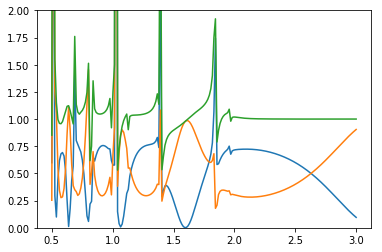

In [6]:
spectra = np.array(spectra);
spectra_T = np.array(spectra_T)
plt.figure();
plt.plot(wavelength_scan, spectra);
plt.plot(wavelength_scan, spectra_T)
plt.plot(wavelength_scan, spectra+spectra_T)
# plt.legend(['reflection', 'transmission'])
# plt.axhline(((3.48-1)/(3.48+1))**2,xmin=0, xmax = max(wavelength_scan))
# plt.axhline(((3.48-1)/(3.48+1)),xmin=0, xmax = max(wavelength_scan), color='r')
#
plt.ylim([0,2])
plt.show()

